SVD + Normalizing
contingency matrix:
[[3557  346]
 [ 500 3479]]


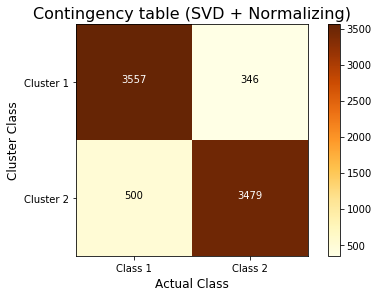


Homogeneity: 0.5101819474548936
Completeness: 0.5104667953932283
V-measure: 0.5103243316756418
Adjusted Rand Score: 0.6167003557037432
Adjusted Mutual Info Score: 0.510137104466011


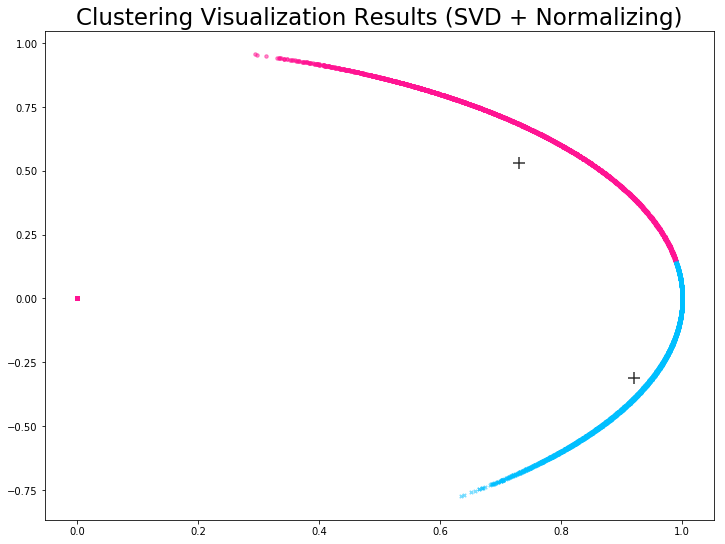



NMF + Normalizing
contingency matrix:
[[3399  504]
 [ 368 3611]]


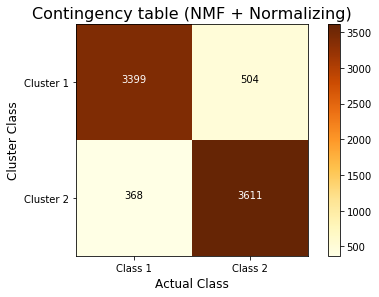


Homogeneity: 0.4992770312116602
Completeness: 0.49994677278348154
V-measure: 0.4996116775464663
Adjusted Rand Score: 0.6063804057272637
Adjusted Mutual Info Score: 0.49923118986179815


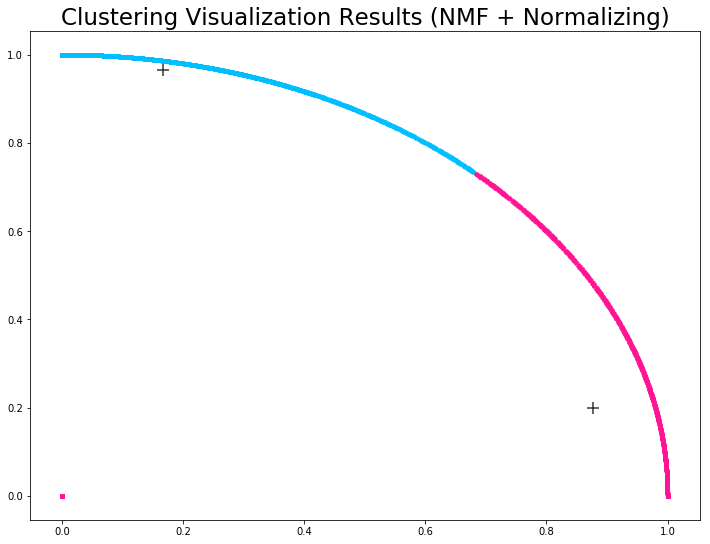



NMF + non-linear transformation
contingency matrix:
[[3611  368]
 [ 421 3482]]


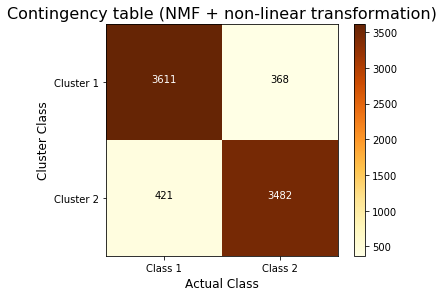


Homogeneity: 0.5308074387175757
Completeness: 0.5309760733079933
V-measure: 0.5308917426213423
Adjusted Rand Score: 0.6396295348201643
Adjusted Mutual Info Score: 0.5307644840022134


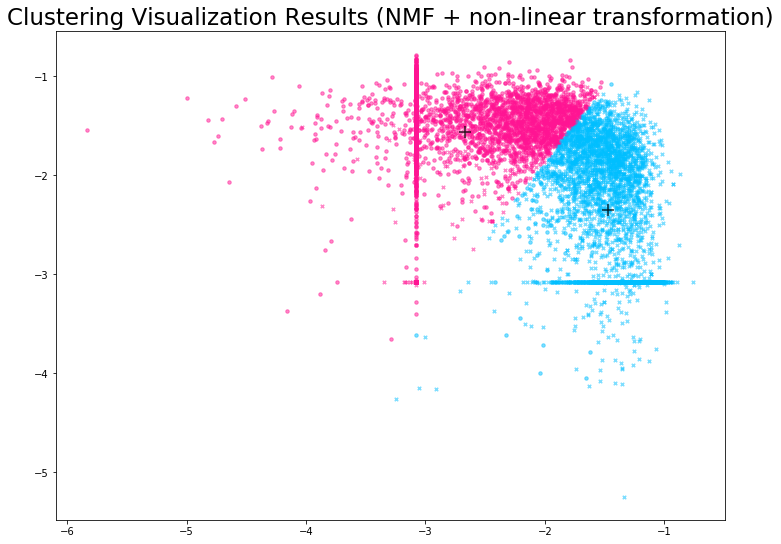



NMF + Normalizing + non-linear transformation
contingency matrix:
[[3766  137]
 [2161 1818]]


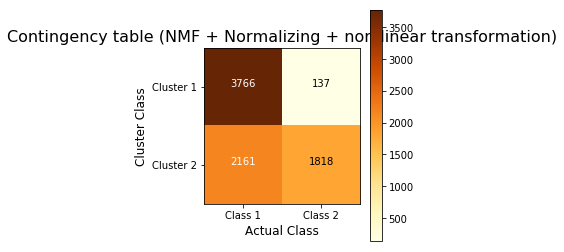


Homogeneity: 0.19742451680641634
Completeness: 0.24427663170078784
V-measure: 0.21836572598289444
Adjusted Rand Score: 0.1737072741189204
Adjusted Mutual Info Score: 0.19735103444437238


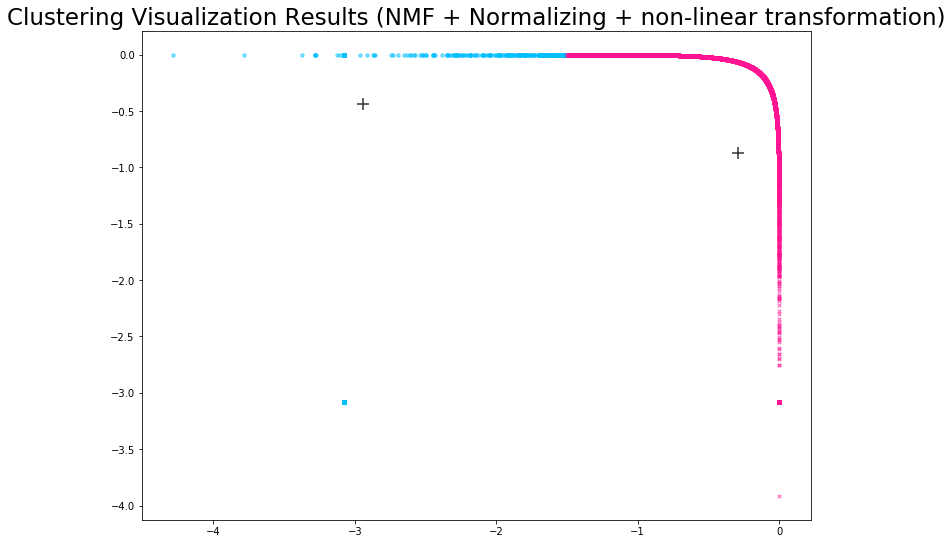

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from math import log
from sklearn.metrics import confusion_matrix
import itertools

# fetch original data
comp_tech_subclasses = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']             
rec_act_subclasses = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=comp_tech_subclasses+rec_act_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

# seperate all data into two classes
labels = [1]*len(dataset.data)
for i in range(len(dataset.data)):
    if dataset.target[i] > 3:
        labels[i] = 0

# trim data
def trim_data(data_list):
    for i in range(len(data_list)):
        temp = re.findall('[a-zA-Z]+', data_list[i])
        ans = []
        for j in range(len(temp)):
            if not temp[j].isdigit():
                ans.append(temp[j])           
        data_list[i] = " ".join(ans)
        
trim_data(dataset.data)

# generate TF-IDF matrix
vectorizer = TfidfVectorizer(min_df=3, stop_words='english', use_idf=True)
X = vectorizer.fit_transform(dataset.data)

# trasform confusion matrix to diagonal as much as possible (only for 2 * 2 sized confusion)
def to_diagonal(confusion):
    maxColIndices = []
    copy = []
    for row in range(len(confusion)):
        curRow = confusion[row]
        index = 0
        value = curRow[0]
        ro = []
        for col in range(len(curRow)):
            ro.append(curRow[col])
            if curRow[col] > value:
                index = col
                value = curRow[col]
        maxColIndices.append(index)
        copy.append(ro)
    res = []
    for i in range(len(confusion)):
        res.insert(maxColIndices[i], copy[i])
    res = np.array(res)
    return res

# contingency table (confusion matrix)
actual_class_names = ['Class 1', 'Class 2']
cluster_class_names = ['Cluster 1', 'Cluster 2']
def plot_contingency_table(cm, title='Contingency table', cmap=plt.cm.YlOrBr):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(actual_class_names))
    plt.xticks(tick_marks, actual_class_names)
    plt.yticks(tick_marks, cluster_class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)    

# plot clustering results
def plot_clusters(actual_labels, clustered_labels, X_2d, centers, reducer):
    plt.figure(figsize=(12,9))
    color = ["deeppink", "deepskyblue"]
    mark = ["o", "x"]
    for i in range(len(labels)):
        plt.scatter(X_2d[i, 0], X_2d[i, 1], s=12, marker=mark[actual_labels[i]], color=color[clustered_labels[i]], alpha=0.5)
    for i in range(2):
        plt.scatter(centers[i, 0], centers[i, 1], marker='+', s=150, linewidths=20, color='k', alpha=0.8)
    plt.title('Clustering Visualization Results (' + reducer + ')', fontsize=23)
    plt.show()
    
# K-Means clustering
def k_means(X_reduced, improve_method, labels):
    km = KMeans(n_clusters=2)
    km.fit(X_reduced)
    
    confusion = metrics.confusion_matrix(labels, km.labels_)
    contingency = to_diagonal(confusion)

    print 'contingency matrix:'
    print contingency
    # Plot non-normalized contingency table
    plt.figure()
    title = 'Contingency table (' + improve_method + ')'
    plot_contingency_table(contingency, title=title)
    plt.show()
    print 
    print 'Homogeneity:', metrics.homogeneity_score(labels, km.labels_)
    print 'Completeness:', metrics.completeness_score(labels, km.labels_)
    print 'V-measure:', metrics.v_measure_score(labels, km.labels_)
    print 'Adjusted Rand Score:', metrics.adjusted_rand_score(labels, km.labels_)
    print 'Adjusted Mutual Info Score:', metrics.adjusted_mutual_info_score(labels, km.labels_)
    # plot clustering visualization results
    if improve_method == 'SVD + Normalizing':
        svd = TruncatedSVD(n_components=2, n_iter=13, random_state=42)
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
        X_reduced = lsa.fit_transform(X)
        km.fit(X_reduced)
    clustered_labels = km.labels_
    centers = km.cluster_centers_
    ## plot results
    plot_clusters(labels, clustered_labels, X_reduced, centers, improve_method)
    print '\n'

improve = ['SVD + Normalizing', 'NMF + Normalizing', 'NMF + non-linear transformation', 'NMF + Normalizing + non-linear transformation']
# improvement1: SVD + Normalizing features
print 'SVD + Normalizing'
svd = TruncatedSVD(n_components = 10, n_iter = 13,random_state = 42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_reduced = lsa.fit_transform(X)
k_means(X_reduced, improve[0], labels)

# improvement2: NMF + Normalizing features
print 'NMF + Normalizing'
nmf = NMF(n_components = 2, random_state = 42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(nmf, normalizer)
X_reduced = lsa.fit_transform(X)
k_means(X_reduced, improve[1], labels)

# improvement3: NMF + non-linear transformation
print 'NMF + non-linear transformation'
nmf = NMF(n_components = 2, random_state = 42)
X_reduced = nmf.fit_transform(X)
for j in range(X_reduced.shape[0]):
    for k in range(X_reduced.shape[1]):
        if X_reduced[j][k] == 0:
            X_reduced[j][k] = -3.08
        else:
            X_reduced[j][k] = log(X_reduced[j][k], 10)
k_means(X_reduced, improve[2], labels)

# improvement4: NMF + Normalizing features + non-linear transformation
print 'NMF + Normalizing + non-linear transformation'
nmf = NMF(n_components = 2, random_state = 42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(nmf, normalizer)
X_reduced = lsa.fit_transform(X)
for j in range(X_reduced.shape[0]):
    for k in range(X_reduced.shape[1]):
        if X_reduced[j][k] == 0:
            X_reduced[j][k] = -3.08
        else:
            X_reduced[j][k] = log(X_reduced[j][k], 10)
k_means(X_reduced, improve[3], labels)

